# RelM: Usage Examples

## Generic Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sps
import matplotlib.pyplot as plt

from collections import Counter
from itertools import product

# Note: imports from the relm module will be done as needed below

## Basic Mechanisms
Using RelM for basic differentially private release is fairly striaghtforward.
For example, suppose that the database consists of records indicating the age group of each patient who received a COVID-19 test on 09 March, 2020.
Each patient is classified as belonging to one of eight age groups: 0-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, and 70+.
One common way to summarise this kind of data is with a histogram.
That is, to report the number of patients that were classified as belonging to each age group.

### Data Wrangling

In [2]:
# Read the raw data
data = pd.read_csv("pcr_testing_age_group_2020-03-09.csv")

# Compute the exact query responses
exact_counts = data["age_group"].value_counts().sort_index()
values = exact_counts.values

### Laplace Mechanism
The Laplace mechanism can be used to produce a differentially private histogram that summarises the data without compromising the privacy of the patients whose data comprise the database. To do so, Laplace noise is added to the count for each age group and the noisy counts are released instead of the exact counts.

#### Basic Usage

In [3]:
# Create a differentially private release mechanism
from relm.mechanisms import LaplaceMechanism
mechanism = LaplaceMechanism(epsilon=0.1, sensitivity=1.0)
perturbed_counts = mechanism.release(values=values.astype(np.float))

#### Visualising the Results
Notice that the magnitude of the differences between the exact counts and perturbed counts depends only on the value of the privacy paramter `epsilon`. Smaller values of epsilon yield larger perturbations. Larger perturbations yeild lower utility.

A simple way to try to understand this effect is to compare the two histograms to one another. If the value of `epsilon` is not too small, then we expect that the two histograms will look similar.

,Age Group,Exact Counts,Perturbed Counts
0,0-9,238,251.031088
1,10-19,386,377.839711
2,20-29,688,690.458008
3,30-39,779,778.062103
4,40-49,621,620.090036
5,50-59,582,579.223553
6,60-69,344,291.545413
7,70+,261,259.537919


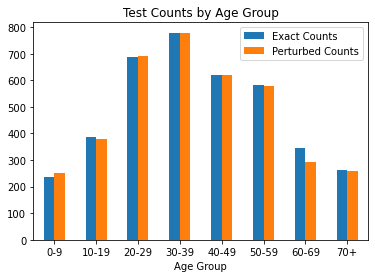

In [4]:
# Extract the set of possible age groups
age_groups = np.sort(data["age_group"].unique())
# Reformat the age group names for nicer display
age_ranges = np.array([a.lstrip("AgeGroup_") for a in age_groups])

# Create a dataframe with both exact and perturbed counts
column_names = ["Age Group", "Exact Counts", "Perturbed Counts"]
column_values = [age_ranges, values, perturbed_counts]
table = {k: v for (k, v) in zip(column_names, column_values)}
df = pd.DataFrame(table)

# Display the two histograms as a table
display(df.style.set_caption("Test Counts by Age Group"))

# Plot the two histograms as bar graphs
df.plot(x="Age Group", title="Test Counts by Age Group", kind="bar", rot=0)
plt.show()

### Geometric Mechanism
In this example, all of the exact counts are integers.  That is because they are the result of so-called counting queries. The perturbed counts produced by the Laplace mechanism are real-valued. In some applications, e.g. when some downstream processing assumes it will receive integer-valued data, we may need the perturbed counts to be integers. One way to achieve this is by simply rounding the outputs of the Laplace mechanism to the nearest integer. Because this differentially private release mechanisms are not affected by this kind of post-processing, doing so will not affect any privacy guarantees.

Alternatively, we could use the geometric mechanism to compute the permuted counts.  The geometric mechanism is simply a discrete version of the Laplace mechanism and it produces integer valued perturbations.

#### Basic Usage

In [5]:
# Create a differentially private release mechanism
from relm.mechanisms import GeometricMechanism
mechanism = GeometricMechanism(epsilon=0.1, sensitivity=1.0)
perturbed_counts = mechanism.release(values=values)

#### Visualising the Results
As with the Laplace mechanism, we can plot the exact histogram alongside the differentially private histogram to get an idea if we have used too small a value for `epsilon`.

,Age Group,Exact Counts,Perturbed Counts
0,0-9,238,232
1,10-19,386,386
2,20-29,688,688
3,30-39,779,785
4,40-49,621,599
5,50-59,582,592
6,60-69,344,361
7,70+,261,256


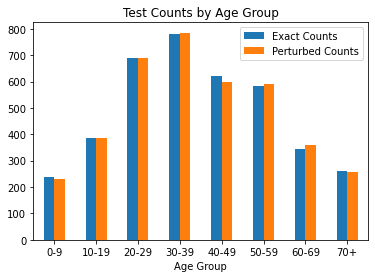

In [6]:
# Create a dataframe with both exact and perturbed counts
column_values = [age_ranges, values, perturbed_counts]
table = {k: v for (k, v) in zip(column_names, column_values)}
df = pd.DataFrame(table)

# Display the two histograms as a table
display(df.style.set_caption("Test Counts by Age Group"))

# Plot the two histograms as bar graphs
df.plot(x="Age Group", title="Test Counts by Age Group", kind="bar", rot=0)
plt.show()

### Exponential Mechanism

#### Basic Usage
The `ExponentialMechanism` does not lend itself to vectorised queries as easily as the `LaplaceMechanism` or `GeometricMechanism`.  So, to produce a histogram query that is comparable to those discussed above we wrap the query releases in a loop and compute them one at a time.

In [7]:
# Create a differentially private release mechanism
from relm.mechanisms import ExponentialMechanism

output_range = np.arange(2**10)
utility_function = lambda x: -abs(output_range - x)

perturbed_counts = np.empty(len(values), dtype=np.int)
for i, value in enumerate(values.astype(np.float)):
    mechanism = ExponentialMechanism(epsilon=0.1,
                                     utility_function=utility_function,
                                     sensitivity=1.0,
                                     output_range=output_range)
    
    perturbed_counts[i] = mechanism.release(values=value)

#### Visualising the Results

,Age Group,Exact Counts,Perturbed Counts
0,0-9,238,220
1,10-19,386,380
2,20-29,688,664
3,30-39,779,813
4,40-49,621,629
5,50-59,582,598
6,60-69,344,406
7,70+,261,253


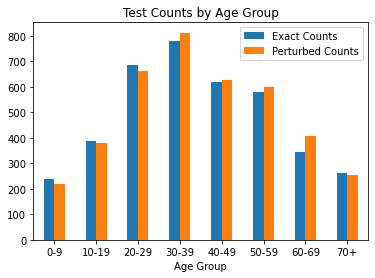

In [8]:
# Create a dataframe with both exact and perturbed counts
column_values = [age_ranges, values, perturbed_counts]
table = {k: v for (k, v) in zip(column_names, column_values)}
df = pd.DataFrame(table)

# Display the two histograms as a table
display(df.style.set_caption("Test Counts by Age Group"))

# Plot the two histograms as bar graphs
df.plot(x="Age Group", title="Test Counts by Age Group", kind="bar", rot=0)
plt.show()

## Sparse Mechanisms
We currently have four mechanisms that take advantage of sparsity to answer more queries about the data for a given privacy budget. All of these mechanisms compare noisy query responses to a noisy threshold value. If a noisy response does not exceed the noisy threshold, then the mechanism reports only that the value did not exceed the threshold.  Otherwise, the mechanism reports that the value exceeded the threshold. Furthermore, in the latter case some mechanisms release more information about the underlying exact count. This extra information is computed using some other differentially private mechanism and therefore imposes some additional privacy costs.

### Data Wrangling
All three of our mechanims share an input format. We require a sequence of exact query responses and a threshold value to which these responses will be compared.

In [9]:
# Read the raw data
fp = '20200811_QLD_dummy_dataset_individual_v2.xlsx'
data = pd.read_excel(fp)

# Limit our attention to the onset date column
data.drop(list(data.columns[1:]), axis=1, inplace=True)  

# Remove data with no onset date listed
mask = data['ONSET_DATE'].notna()
data = data[mask]

# Compute the exact query responses
queries = [(pd.Timestamp('2020-01-01')  + i*pd.Timedelta('1d'),) for i in range(366)]
exact_counts = dict.fromkeys(queries, 0)
exact_counts.update(data.value_counts())

dates, values = zip(*sorted(exact_counts.items()))
values = np.array(values, dtype=np.float64)

### Above Threshold
The simplest of the sparse release mechanisms simply reports the index of the first query response that exceeds the specified threshold.

#### Basic Usage

In [10]:
from relm.mechanisms import AboveThreshold
mechanism = AboveThreshold(epsilon=1.0, sensitivity=1.0, threshold=100)
index = mechanism.release(values)

#### Empirical Distribution
Because `AboveThreshold` returns a single index, we can run many experiments and plot a histogram of the results of those experiments to get an empirical estimate of the distribution of the mechanism's output.

In [11]:
TRIALS = 2**10
threshold = 100
results = np.zeros(TRIALS)
for i in range(TRIALS):
    mechanism = AboveThreshold(epsilon=1.0, sensitivity=1.0, threshold=threshold)
    index = mechanism.release(values)
    results[i] = index    

#### Visualising the Results

The index of the first exact count that exceeds the threshold is: 105



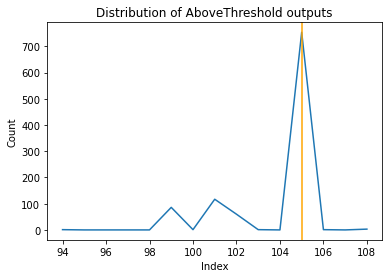

In [12]:
print("The index of the first exact count that exceeds the threshold is: %i\n" % np.argmax(values >= threshold))

histogram = dict.fromkeys(np.arange(min(results), max(results)), 0)
histogram.update(Counter(results))

plt.xlabel("Index")
plt.ylabel("Count")
plt.title("Distribution of AboveThreshold outputs")
plt.plot(list(histogram.keys()), list(histogram.values()))
plt.axvline(x=np.argmax(values >= threshold), color='orange')

### Sparse Indicator
The `SparseIndicator` is a straightforward extension of the `AboveThreshold` mechanism.  Here, we find the indices of several values that exceeds the specified threshold. The number of indices that this mechanism will return is controlled by the `cutoff` parameter.

#### Basic Usage

In [13]:
from relm.mechanisms import SparseIndicator
mechanism = SparseIndicator(epsilon=1.0, sensitivity=1.0, threshold=100, cutoff=3)
indices = mechanism.release(values)

#### Visualising the Results

In [14]:
TRIALS = 16
cutoff = 4
threshold = 100
indices = np.empty((TRIALS, cutoff), dtype=np.int)
for i in range(TRIALS):
    mechanism = SparseIndicator(epsilon=1.0, sensitivity=1.0, threshold=threshold, cutoff=cutoff)
    indices[i] = mechanism.release(values)
    
df = pd.DataFrame(indices,
                  columns=["Hit %i" % (j+1) for j in range(cutoff)],
                  index=["Trial %i" % i for i in range(TRIALS)])
display(df)

,Hit 1,Hit 2,Hit 3,Hit 4
Trial 0,105,107,108,109
Trial 1,106,107,108,109
Trial 2,99,102,105,106
Trial 3,101,106,107,108
Trial 4,99,101,105,107
Trial 5,102,105,106,107
Trial 6,99,101,105,106
Trial 7,98,105,108,109
Trial 8,105,106,107,108
Trial 9,97,101,106,108


### Sparse Numeric
The `SparseNumeric` mechanism returns perturbed values alongside the indices of the values that exceeded the threshold.

#### Basic Usage

In [15]:
from relm.mechanisms import SparseNumeric
mechanism = SparseNumeric(epsilon=1.0, sensitivity=1.0, threshold=100, cutoff=3)  
indices, perturbed_values = mechanism.release(values)

#### Visualising the Results
Notice that in these experiemnts we have set `epsilon=4.0`.  This is a larger value than we use in the other sparse mechanisms. Because the `SparseNumeric` mechanism releases more information about the underlying exact query responses than does `SparseIndices`, for example, it consumes the available privacy budget more quickly.  To achieve comparable utility with respect the the indices returned by the two mechanisms, we therefore need to a larger value for `epsilon`.

In [16]:
TRIALS = 2**4
cutoff = 3
threshold = 100
indices = np.empty(shape=(TRIALS, cutoff), dtype=np.int)
perturbed_values = np.empty(shape=(TRIALS, cutoff), dtype=np.float)
for i in range(TRIALS):
    mechanism = SparseNumeric(epsilon=4.0, sensitivity=1.0, threshold=threshold, cutoff=cutoff)  
    indices[i], perturbed_values[i] = mechanism.release(values)

hit_names = ["Hit %i" % (j+1) for j in range(cutoff)]
value_names = ["Value %i" % (j+1) for j in range(cutoff)]
column_pairs = zip(hit_names, value_names)
column_names = [val for pair in column_pairs for val in pair]
value_pairs = zip(indices.transpose(), perturbed_values.transpose())
column_values = [val for pair in value_pairs for val in pair]
table = {k: v for (k, v) in zip(column_names, column_values)}
df = pd.DataFrame(table, index=["Trial %i" % i for i in range(TRIALS)])
display(df)

,Hit 1,Value 1,Hit 2,Value 2,Hit 3,Value 3
Trial 0,105,117.262669,108,123.009376,109,125.388963
Trial 1,105,118.547658,106,104.064030,107,100.469278
Trial 2,101,95.011741,105,117.134398,106,103.448672
Trial 3,105,118.249159,108,111.530956,109,129.435022
Trial 4,105,113.119498,106,104.066018,107,99.563147
Trial 5,105,116.876166,106,94.882927,108,117.329407
Trial 6,102,91.500096,105,112.960520,106,103.647990
Trial 7,102,93.430881,105,118.074966,107,101.492441
Trial 8,105,115.851676,107,99.761099,108,115.686010
Trial 9,101,95.691499,105,115.727988,106,104.892038


### Report Noisy Max

#### Basic Usage

In [17]:
from relm.mechanisms import ReportNoisyMax
mechanism = ReportNoisyMax(epsilon=1.0)  
index, perturbed_value = mechanism.release(values)

#### Empirical Distribution
Because `ReportNoisyMax` returns a single index and a single value, we can run many experiments and plot a histogram of the results of those experiments to get an empirical estimate of the distribution of the mechanism's output.

In [18]:
TRIALS = 2**10
indices = np.zeros(TRIALS)
perturbed_values = np.zeros(TRIALS)
for i in range(TRIALS):
    mechanism = ReportNoisyMax(epsilon=0.1)
    indices[i], perturbed_values[i] = mechanism.release(values)

#### Visualising the Results
The `ReportNoisyMax` mechanism resturns two values, an index and a perturbed query response. We analyze the distribution of each output individually. 

##### Indices

The index of the greatest exact count is: 128



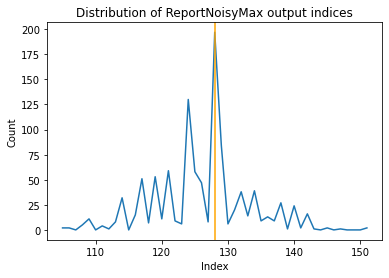

In [19]:
print("The index of the greatest exact count is: %i\n" % np.argmax(values))

histogram = dict.fromkeys(np.arange(min(indices), max(indices)), 0)
histogram.update(Counter(indices))

plt.xlabel("Index")
plt.ylabel("Count")
plt.title("Distribution of ReportNoisyMax output indices")
plt.plot(list(histogram.keys()), list(histogram.values()))
plt.axvline(x=np.argmax(values), color='orange')

##### Perturbed Values

The greatest exact count is: 156



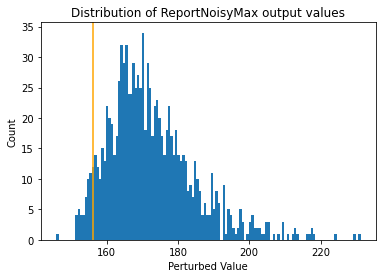

In [20]:
print("The greatest exact count is: %i\n" % np.max(values))

#histogram = dict.fromkeys(np.arange(min(results), max(results)), 0)
#histogram.update(Counter(results))

plt.hist(perturbed_values, bins=128)

plt.xlabel("Perturbed Value")
plt.ylabel("Count")
plt.title("Distribution of ReportNoisyMax output values")
plt.axvline(x=np.max(values), color='orange')

## Correlated Noise Mechanisms

### Data Wrangling

In [21]:
# Generate some synthetic data
data = pd.DataFrame()
test_results = np.random.choice(["Negative", "Positive", "N/A"], size=4000, p=[0.55,0.35,0.1]) 
data["Test Result"] = test_results

# Compute a histogram representation of the data
from relm.histogram import Histogram
hist = Histogram(data)
real_database = hist.get_db()
db_size = real_database.size
db_l1_norm = real_database.sum()

# Specify the queries to be answered
queries = [[{"Test Result": "Negative"}, {"Test Result": "Positive"}],
           [{"Test Result": "Positive"}, {"Test Result": "N/A"}],
           [{"Test Result": "Negative"}, {"Test Result": "N/A"}]]
num_queries = len(queries)
queries = sps.vstack([hist.get_query_vector(q) for q in queries])

# Compute the exact query responses
values = (queries @ real_database)/real_database.sum()

### SmallDB Mechanism

#### Basic Usage

In [22]:
from relm.mechanisms import SmallDB
mechanism = SmallDB(epsilon=0.01, alpha=0.1)
synthetic_database = mechanism.release(values, queries, db_size, db_l1_norm)

#### Visualising the Results

In [23]:
TRIALS = 2**4
synthetic_responses = np.empty((TRIALS, queries.shape[0]))
for i in range(TRIALS):
    mechanism = SmallDB(epsilon=0.01, alpha=0.1)
    synthetic_database = mechanism.release(values, queries, db_size, db_l1_norm)
    synthetic_responses[i] = (queries @ synthetic_database) / synthetic_database.sum()
    
df = pd.DataFrame(data=np.row_stack((values, synthetic_responses)),
                  columns=["Query %i" % i for i in range(queries.shape[0])],
                  index=["Exact Responses"] + ["TRIAL %i" % i for i in range(TRIALS)])

display(df)

,Query 0,Query 1,Query 2
Exact Responses,0.894250,0.451250,0.654500
TRIAL 0,0.903333,0.470000,0.626667
TRIAL 1,0.953333,0.466667,0.580000
TRIAL 2,0.890000,0.556667,0.553333
TRIAL 3,0.976667,0.300000,0.723333
TRIAL 4,0.906667,0.466667,0.626667
TRIAL 5,0.880000,0.460000,0.660000
TRIAL 6,0.903333,0.450000,0.646667
TRIAL 7,0.843333,0.446667,0.710000
TRIAL 8,0.963333,0.463333,0.573333


### Online Multiplicative Weights Mechanism

#### Basic Usage

In [24]:
from relm.mechanisms import PrivateMultiplicativeWeights
mechanism = PrivateMultiplicativeWeights(epsilon=100.0, alpha=0.1, num_queries=10000, db_size=db_size, db_l1_norm=db_l1_norm)
dp_responses = mechanism.release(values, queries)

In [25]:
print(values)
print(dp_responses)

[0.89425 0.45125 0.6545 ]
[0.89488512 0.4513771  0.66694427]


In [32]:
for i in range(5):
    test_responses = mechanism.release(values, queries)
    print(test_responses)

[0.71523707 0.61561025 0.66915268]
[0.71523707 0.61561025 0.66915268]
[0.71523707 0.61561025 0.66915268]
[0.71523707 0.61561025 0.66915268]
[0.71523707 0.61561025 0.66915268]
